In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import torch
import torchaudio
import torch.nn.functional as F
from emb_demixing.speaker_extractor import SPEAKER_EMBEDDING

from sklearn.cluster import AgglomerativeClustering
import numpy as np

In [2]:
spkr_extractor = SPEAKER_EMBEDDING()
spkr_extractor = spkr_extractor.cuda()
spkr_extractor = spkr_extractor.eval()

!!! STUDENT MODEL LOADED !!! from:  /home/djlee/emb_demixing/save/exp_1/model/model000000623.model


In [3]:
wav_files_iter = torch.load('/home/djlee/LibriMix/files/dev_mix_clean_files.pt')

In [4]:
wav_files_iter[:10]

['/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/3081-166546-0081_2277-149896-0026.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/2086-149220-0004_777-126732-0075.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/5895-34615-0013_6313-76958-0018.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/422-122949-0018_6345-64257-0000.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/2035-147960-0014_174-84280-0013.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/3000-15664-0007_6295-64301-0014.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/6313-76958-0011_5338-24640-0003.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/7850-73752-0019_8297-275155-0007.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/652-129742-0005_174-50561-0013.wav',
 '/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/6345-93306-0005_422-122949-0012.wav']

In [5]:
'''
for i, file in enumerate(wav_files_iter):
    print(file)
    mixed_wav, _ = torchaudio.load(file)
    num_segs = mixed_wav.shape[-1]//16000
    minimum = 1
    partial_embs = []
    index = 0

    for i in range(num_segs-1):
        emb_a, emb_b = spkr_extractor(mixed_wav[:, i*16000: i*16000+32000].cuda(), iter=True)
        #print("{:.4f}".format(F.cosine_similarity(emb_a, emb_b, dim=1).cpu().detach().item()))
        partial_embs.append(emb_a.cpu().detach().numpy())
        partial_embs.append(emb_b.cpu().detach().numpy())

    break
'''
file ='/home/djlee/database/Libri2Mix/wav16k/max/dev/mix_clean/652-129742-0005_174-50561-0013.wav'
mixed_wav, _ = torchaudio.load(file)
num_segs = mixed_wav.shape[-1]//16000
minimum = 1
partial_embs = []
index = 0

for i in range(num_segs-1):
    emb_a, emb_b = spkr_extractor(mixed_wav[:, i*16000: i*16000+32000].cuda(), iter=True)
    #print("{:.4f}".format(F.cosine_similarity(emb_a, emb_b, dim=1).cpu().detach().item()))
    partial_embs.append(emb_a.cpu().detach().numpy())
    partial_embs.append(emb_b.cpu().detach().numpy())

In [6]:
partial_embs = np.array(partial_embs).squeeze(1)
partial_embs.shape

(18, 192)

In [18]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(metric='cosine',linkage='average').fit(partial_embs)
labels = clustering.labels_

In [19]:
labels

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [16]:
from sklearn.cluster import SpectralClustering

sc_cluster = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',\
                                eigen_solver='amg', eigen_tol=1e-10, random_state=0).fit(partial_embs)

In [17]:
sc_cluster.labels_

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1], dtype=int32)

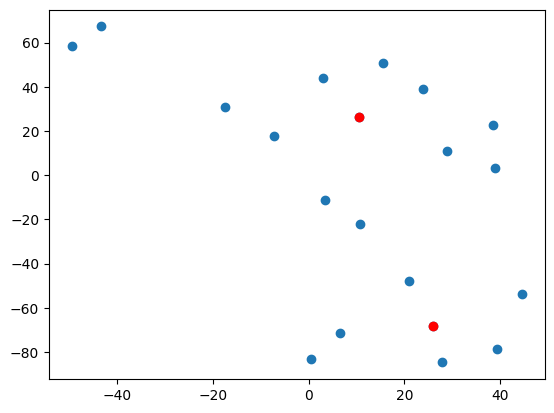

In [8]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

n_components = 2
model = TSNE(n_components=n_components, perplexity=5)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(partial_embs)
centres = kmeans.cluster_centers_

all_points = np.concatenate((partial_embs, centres), axis=0)
all_points = model.fit_transform(all_points)

plt.scatter(all_points[:,0], all_points[:,1])
plt.scatter(all_points[-2:,0], all_points[-2:,1], marker='o', c='r')
plt.show()